In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
from pathlib import Path
import IPython.display as ipd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission.7z
sample_submission.csv
test
test.7z
train
train.7z



In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(check_output(["ls", "../input/train"]).decode("utf8"))

folders = os.listdir("../input/train/audio")
print(folders)

audio
LICENSE
README.md
testing_list.txt
validation_list.txt

['bed', 'go', 'one', 'right', 'five', 'wow', 'nine', 'seven', 'stop', 'house', 'four', 'two', 'left', 'eight', 'three', 'cat', 'dog', 'up', 'off', 'zero', 'happy', 'bird', 'no', 'yes', 'six', 'tree', 'sheila', 'on', 'down', 'marvin', '_background_noise_']


## Some starter script to help with the data processing

In [3]:
train_audio_path = '../input/train/audio'

train_labels = os.listdir(train_audio_path)
train_labels.remove('_background_noise_')
print(f'Number of labels: {len(train_labels)}')

labels_to_keep = ['yes', 'no', 'up', 'down', 'left',
                  'right', 'on', 'off', 'stop', 'go', 'silence']

train_file_labels = dict()
for label in train_labels:
    files = os.listdir(train_audio_path + '/' + label)
    for f in files:
        train_file_labels[label + '/' + f] = label

train = pd.DataFrame.from_dict(train_file_labels, orient='index')
train = train.reset_index(drop=False)
train = train.rename(columns={'index': 'file', 0: 'folder'})
train = train[['folder', 'file']]
train = train.sort_values('file')
train = train.reset_index(drop=True)
print(train.shape)

def remove_label_from_file(label, fname):
    return fname[len(label)+1:]

train['file'] = train.apply(lambda x: remove_label_from_file(*x), axis=1)
train['label'] = train['folder'].apply(lambda x: x if x in labels_to_keep else 'unknown')

Number of labels: 30
(64721, 2)


In [67]:
train['path']=train.apply(lambda u: "train/"+u['folder']+"/"+u['file'],1)

In [8]:
labels=sorted(list(set(train['label']))+['silence'])
str(labels)

"['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop', 'unknown', 'up', 'yes']"

In [9]:
labels_map={v:u for u,v in enumerate(labels)}

In [10]:
train['target']=train['label'].map(lambda u: labels_map[u])

In [36]:
train['subject']=train['file'].map(lambda u: u.split("_")[0])

In [45]:
subject_map={v:u for u,v in enumerate(np.random.permutation(list(set(train['subject']))))}
len(subject_map)

1881

In [46]:
train['subject_id']=train['subject'].map(lambda u: subject_map[u])

In [47]:
train['id']=np.random.permutation(range(len(train)))

In [48]:
train=train.sort_values(['id'])

In [49]:
train['id'].max(),train['id'].min()

(64720, 0)

In [50]:
train['fold']=train['subject_id'].map(lambda u: u%5)

In [68]:
train.head(5)

folder                   file    label  \
16241    four  f0edc767_nohash_0.wav  unknown   
43866  sheila  8eb4a1bf_nohash_0.wav  unknown   
31754     off  4ca37738_nohash_0.wav      off   
27483    nine  8134f43f_nohash_3.wav  unknown   
48200    stop  86478fab_nohash_1.wav     stop   

                                     path  target  id  fold   subject  \
16241    train/four/f0edc767_nohash_0.wav       9   0     2  f0edc767   
43866  train/sheila/8eb4a1bf_nohash_0.wav       9   1     3  8eb4a1bf   
31754     train/off/4ca37738_nohash_0.wav       4   2     3  4ca37738   
27483    train/nine/8134f43f_nohash_3.wav       9   3     0  8134f43f   
48200    train/stop/86478fab_nohash_1.wav       8   4     2  86478fab   

       subject_id  
16241         897  
43866        1128  
31754         808  
27483        1775  
48200         362

In [69]:
train['fold'].value_counts()

3    13314
2    13172
1    12871
4    12840
0    12524
Name: fold, dtype: int64

In [70]:
df=pd.pivot_table(train, index=['target'],columns=['fold'], values='id',aggfunc='count')
df=df/df.sum(0)
df

fold           0         1         2         3         4
target                                                  
0       0.034494  0.036283  0.034998  0.038456  0.037928
1       0.036410  0.035662  0.037959  0.036052  0.037150
2       0.035532  0.037682  0.035834  0.037630  0.035047
3       0.035133  0.038847  0.036137  0.036127  0.037227
4       0.033216  0.037604  0.037124  0.037780  0.036215
5       0.035292  0.036283  0.036896  0.037029  0.037305
6       0.034494  0.037138  0.037580  0.037179  0.036371
8       0.036809  0.037682  0.036441  0.036653  0.036293
9       0.646359  0.629244  0.633693  0.630239  0.631386
10      0.036330  0.038769  0.035985  0.035301  0.037150
11      0.035931  0.034807  0.037352  0.037554  0.037928

In [71]:
train.to_csv("../info/train_info.csv",index=None)

In [66]:
train.shape

(64721, 9)

In [7]:
str(set(train['folder']))

"{'happy', 'seven', 'three', 'five', 'on', 'house', 'no', 'go', 'six', 'four', 'stop', 'one', 'up', 'bird', 'yes', 'down', 'bed', 'marvin', 'nine', 'right', 'sheila', 'cat', 'two', 'left', 'wow', 'eight', 'off', 'dog', 'tree', 'zero'}"

In [8]:
str(set(train['label']))

"{'go', 'left', 'stop', 'unknown', 'up', 'off', 'yes', 'on', 'right', 'down', 'no'}"

In [12]:
train['target'].value_counts()

9     41039
8      2380
11     2377
10     2375
3      2375
1      2372
6      2367
5      2367
0      2359
4      2357
2      2353
Name: target, dtype: int64

In [15]:
train['label'].value_counts()

unknown    41039
stop        2380
yes         2377
no          2375
up          2375
go          2372
on          2367
right       2367
down        2359
off         2357
left        2353
Name: label, dtype: int64

In [6]:
import scipy.io.wavfile as wavefile
import scipy.signal

In [7]:
def f(x):
    f, t, Sxx = scipy.signal.spectrogram(x)
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    widths = np.arange(1, 21)
    cwtmatr = scipy.signal.cwt(x, scipy.signal.ricker, widths)
    print (cwtmatr.mean())
    #cwtmatr=cwtmatr-cwtmatr.mean()
    #cwtmatr=np.log1p(np.abs(cwtmatr))*np.sign(cwtmatr)
    plt.imshow(cwtmatr, cmap='gray', aspect='auto',  vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    #plt.imshow(cwtmatr, cmap='gray', aspect='auto')
    plt.show()
    plt.plot(cwtmatr.max(0));
    plt.plot(cwtmatr.std(0))
    plt.show()

../input/train/audio/bird/3e7124ba_nohash_0.wav


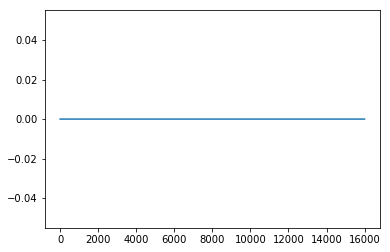

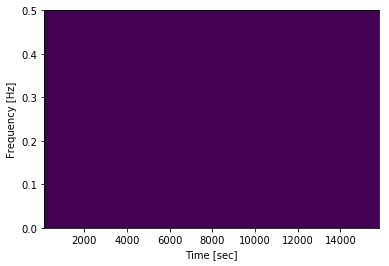

0.0


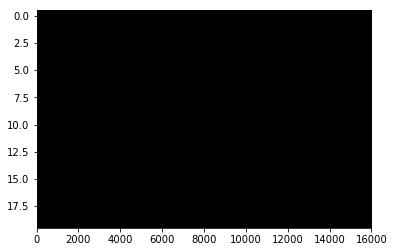

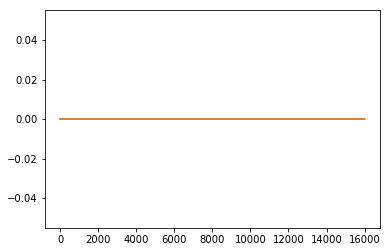

()
-rw-r----- 1 bo bo 32044 Nov 13 16:11 ../input/train/audio/bird/3e7124ba_nohash_0.wav


In [11]:
fname ="../input/train/audio/bird/3e7124ba_nohash_0.wav"
print (fname)
a,b=wavefile.read(fname)
plt.plot(b);plt.show()
f(b)
ipd.Audio(b,rate=16000)
print()
!ls -alrt {fname}

In [10]:
b.sum()

0

../input/train/audio/house/37b03ab1_nohash_2.wav


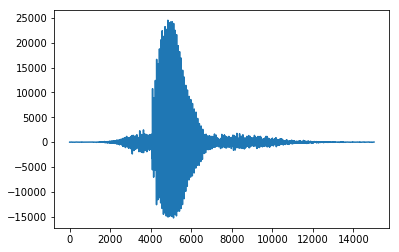

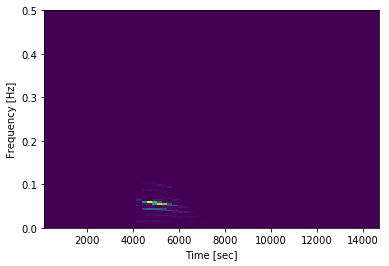

0.0223461251149


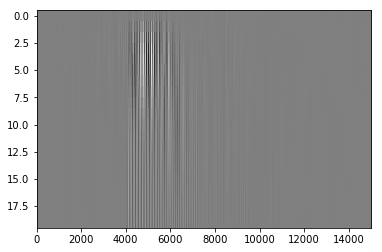

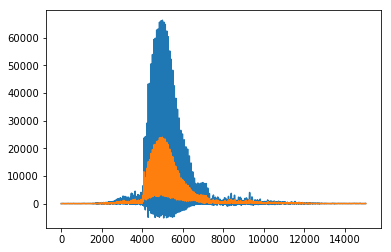


../input/train/audio/house/05cf43ef_nohash_2.wav


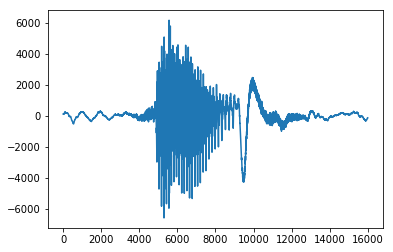

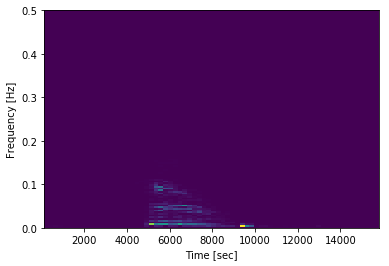

-0.0976912297703


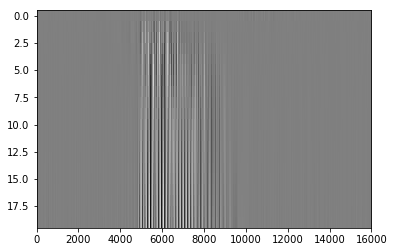

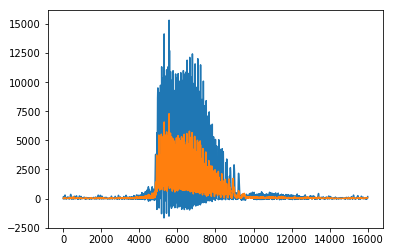


../input/train/audio/house/1657c9fa_nohash_0.wav


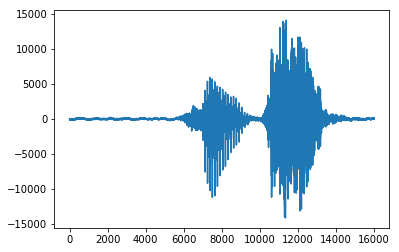

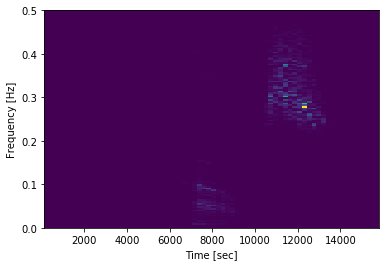

-0.0585566685769


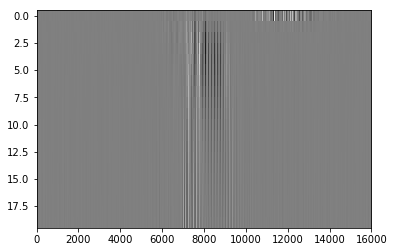

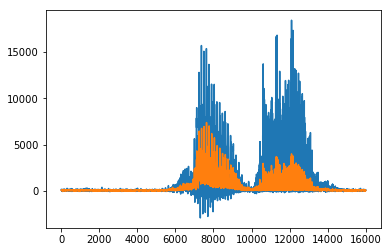


../input/train/audio/house/86478fab_nohash_1.wav


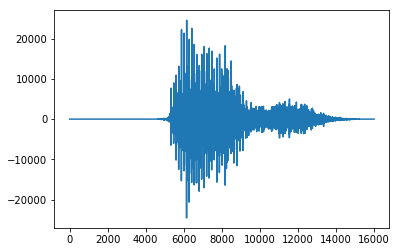

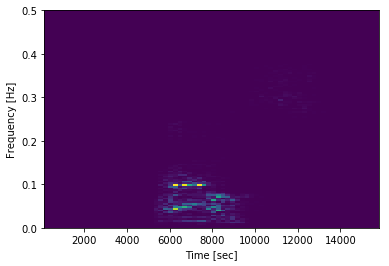

0.000551362310176


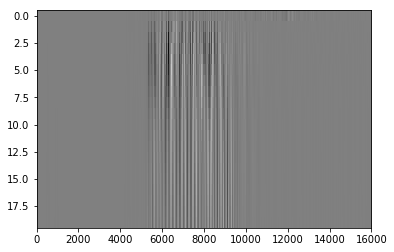

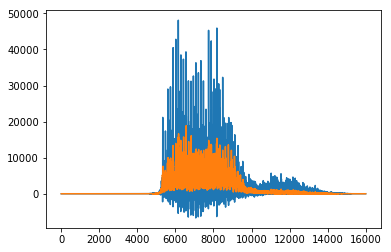


../input/train/audio/house/0137b3f4_nohash_0.wav


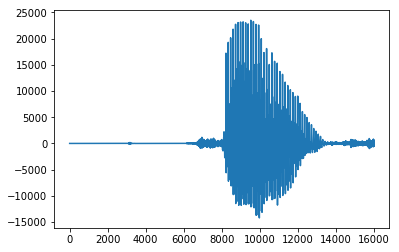

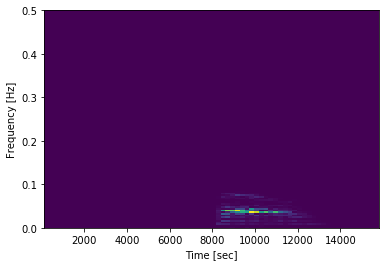

0.0103094194541


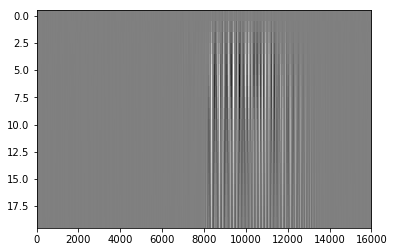

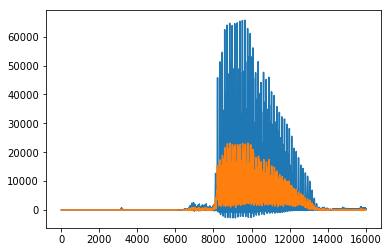


../input/train/audio/house/2335770e_nohash_0.wav


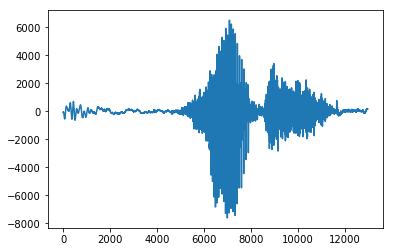

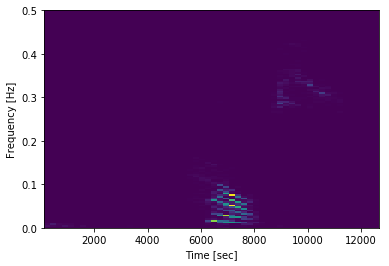

0.106775451302


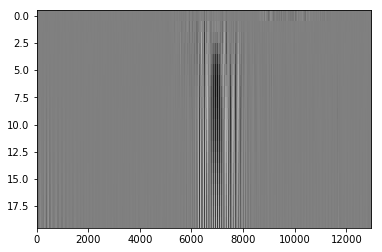

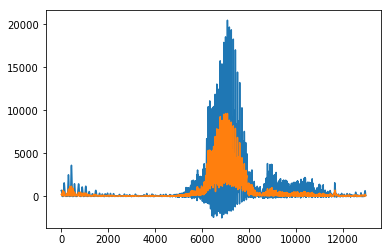


../input/train/audio/house/5fc3ed24_nohash_0.wav


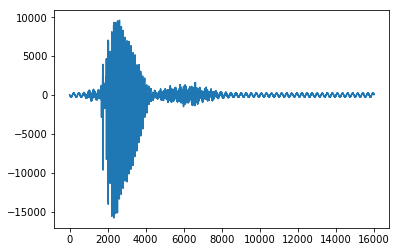

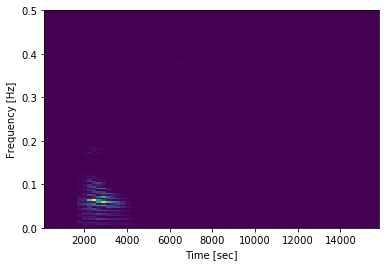

0.220642280432


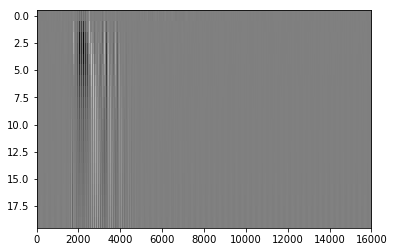

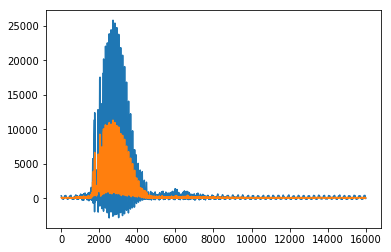


../input/train/audio/house/c0fb6812_nohash_0.wav


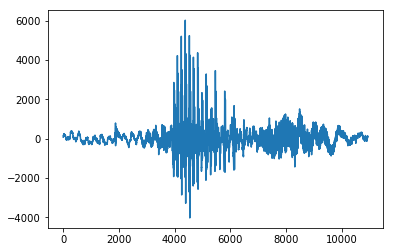

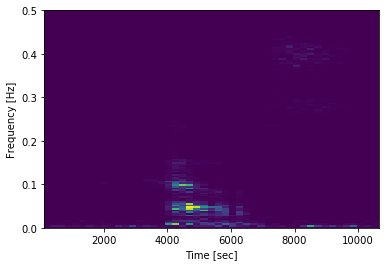

0.485371389115


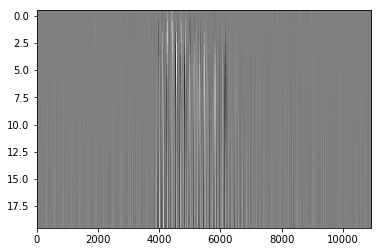

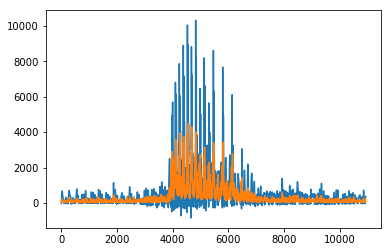


../input/train/audio/house/c84f9b5c_nohash_1.wav


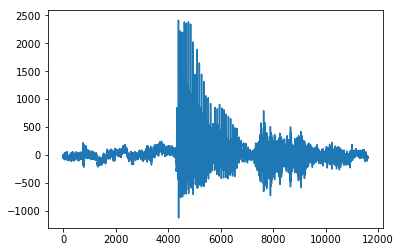

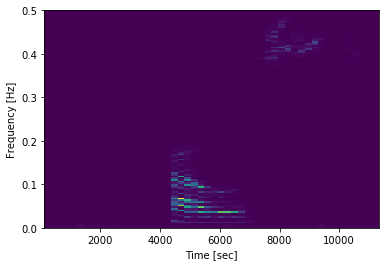

-0.211915255225


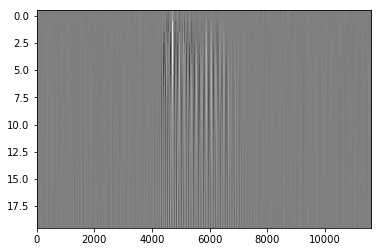

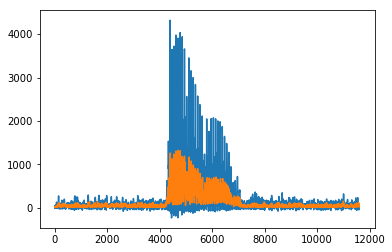


../input/train/audio/house/c4500713_nohash_0.wav


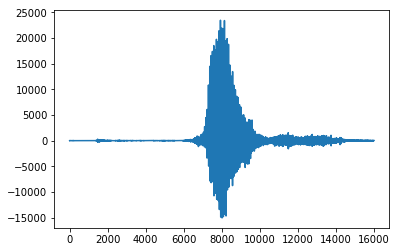

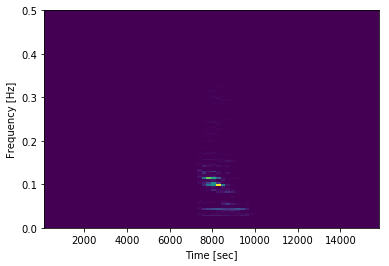

0.0101437846215


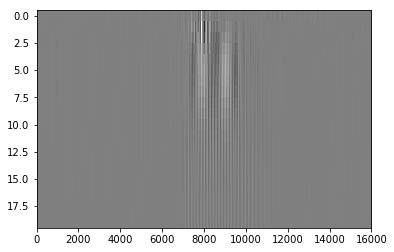

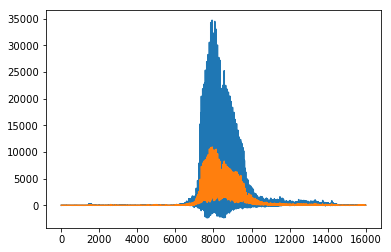

In [274]:
lst=!ls ../input/train/audio/house/*.wav
for fname in np.random.choice(lst,10,replace=False):
    print (fname)
    a,b=wavefile.read(fname)
    plt.plot(b);plt.show()
    f(b)
    ipd.Audio(b,rate=16000)
    print()

../input/train/audio/yes/238c112c_nohash_0.wav


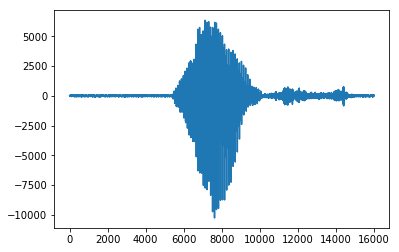

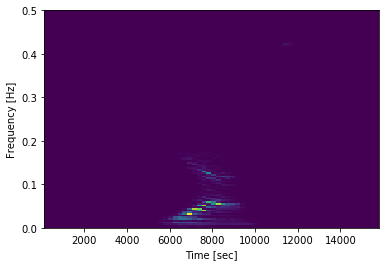

0.0335458515996


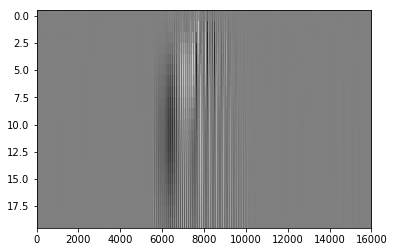

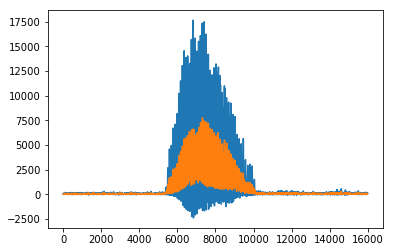


../input/train/audio/yes/48a8a69d_nohash_0.wav


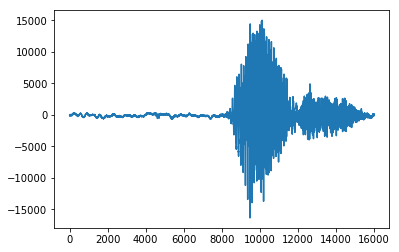

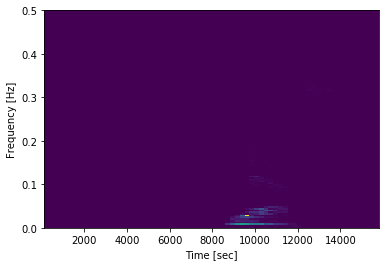

-0.142070675079


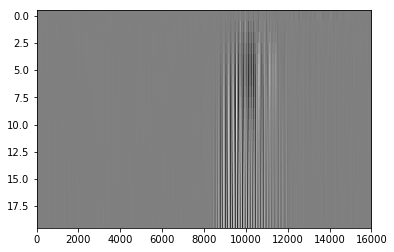

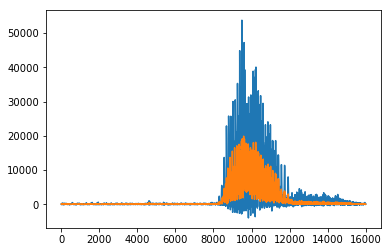


../input/train/audio/yes/f7879738_nohash_0.wav


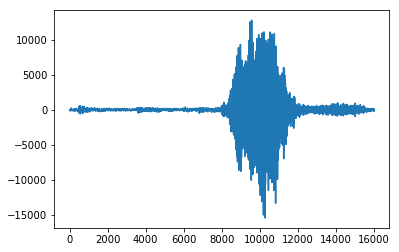

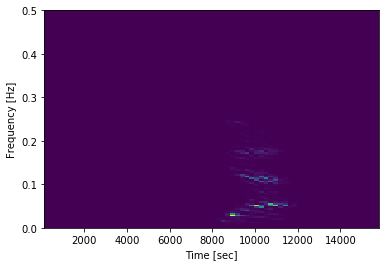

-0.184274889384


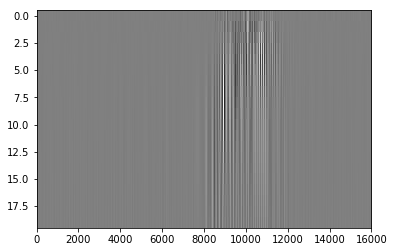

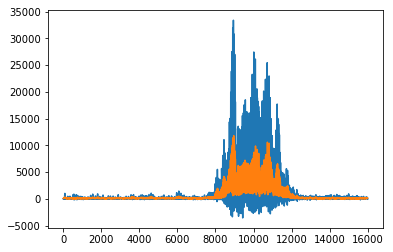


../input/train/audio/yes/66aa0f29_nohash_0.wav


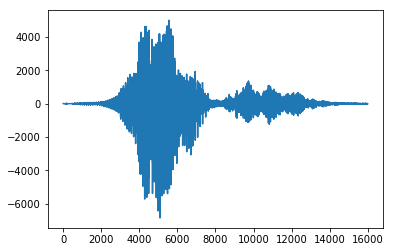

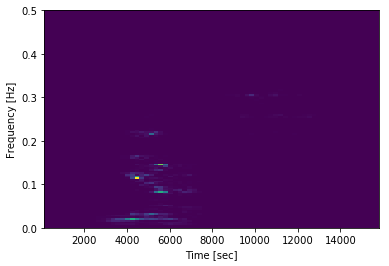

-0.0147187531137


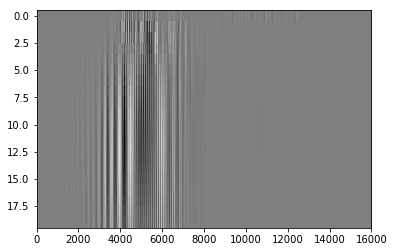

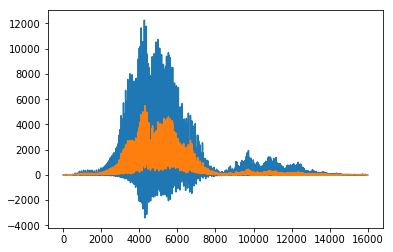


../input/train/audio/yes/6c9223bd_nohash_0.wav


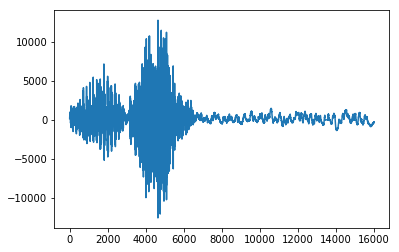

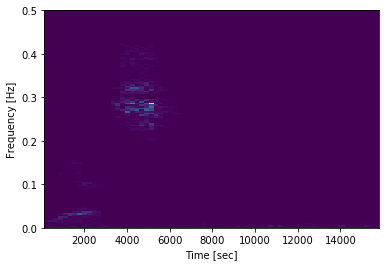

0.614118028863


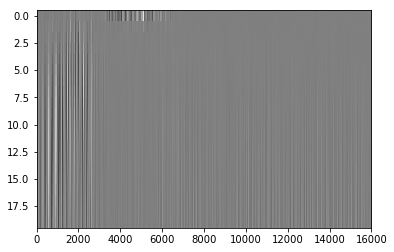

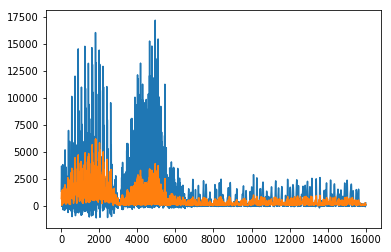


../input/train/audio/yes/16d41d07_nohash_0.wav


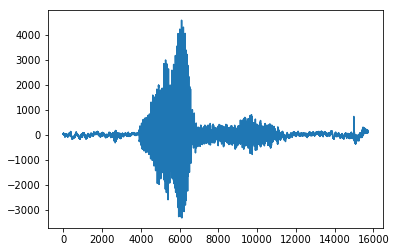

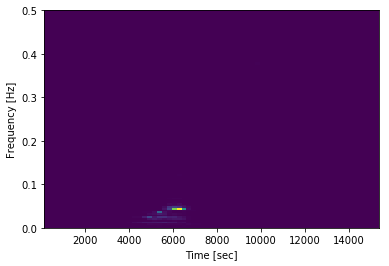

0.336339584075


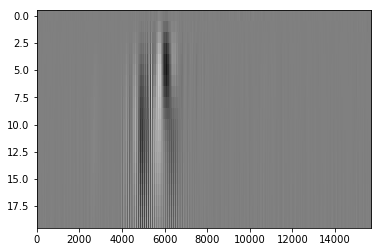

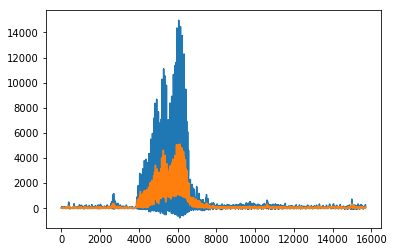


../input/train/audio/yes/62641b88_nohash_0.wav


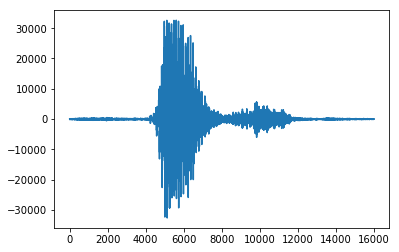

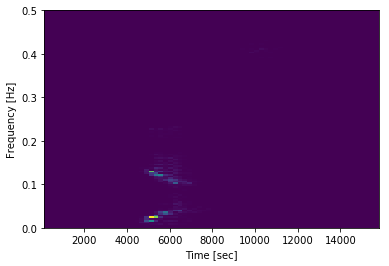

-0.00823317295072


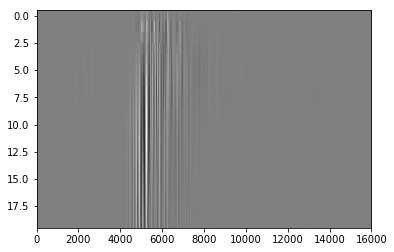

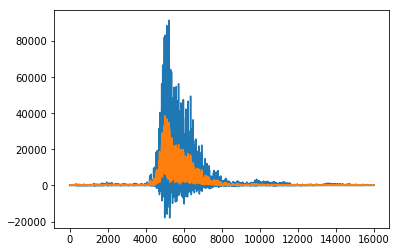


../input/train/audio/yes/6e41a77e_nohash_0.wav


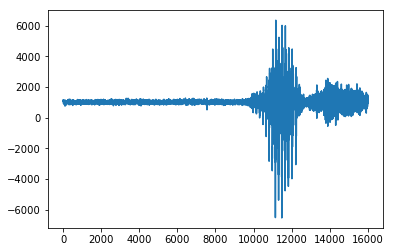

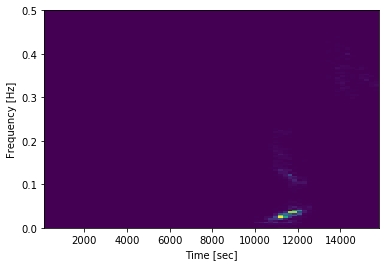

4.42945137815


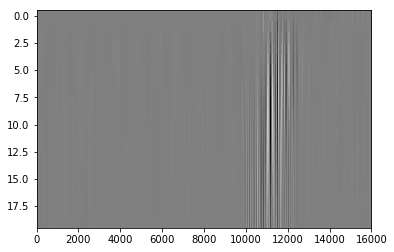

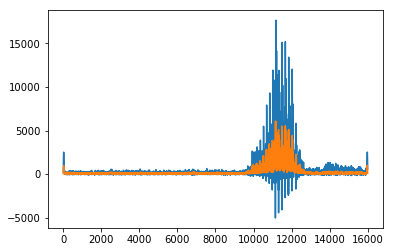


../input/train/audio/yes/0137b3f4_nohash_3.wav


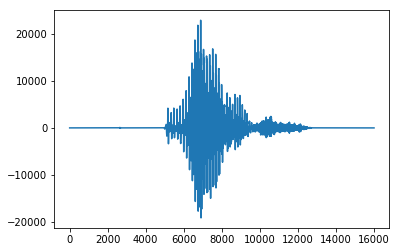

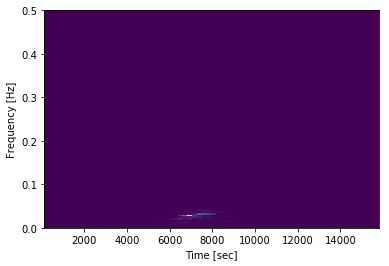

-0.00111022722137


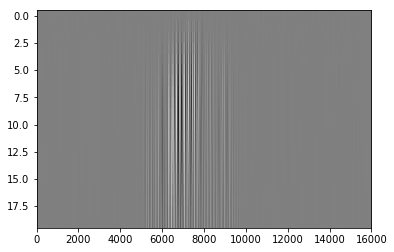

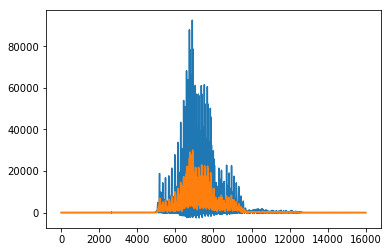


../input/train/audio/yes/0d2bcf9d_nohash_0.wav


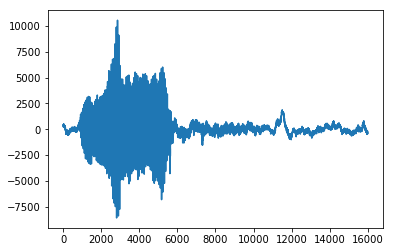

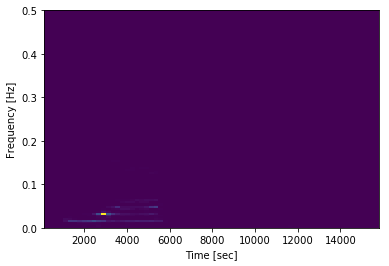

0.0320835621809


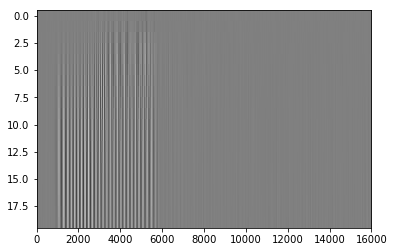

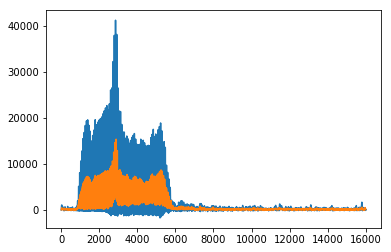

In [275]:
lst=!ls ../input/train/audio/yes/*.wav
for fname in np.random.choice(lst,10,replace=False):
    print (fname)
    a,b=wavefile.read(fname)
    plt.plot(b);plt.show()
    f(b)
    ipd.Audio(b,rate=16000)
    print()

../input/train/audio/no/6366f61a_nohash_1.wav


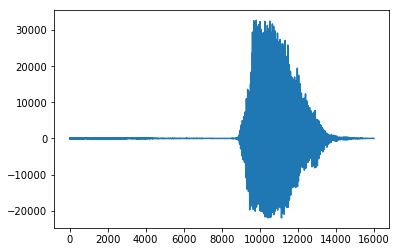

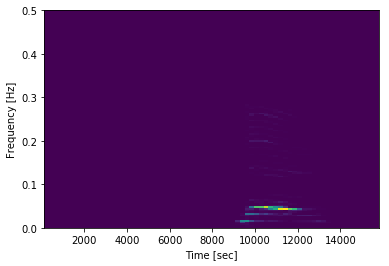

0.0291057322819


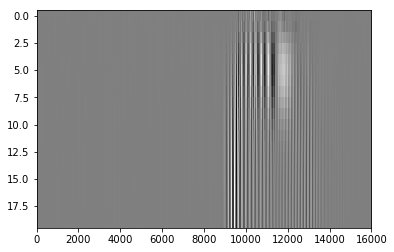

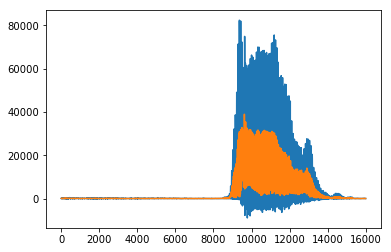


../input/train/audio/no/31d31fa0_nohash_0.wav


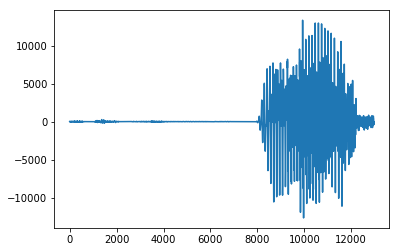

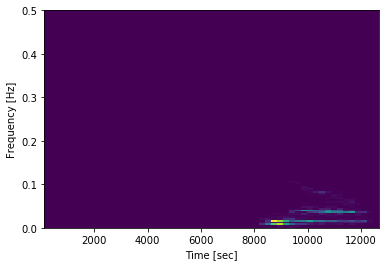

0.3716842776


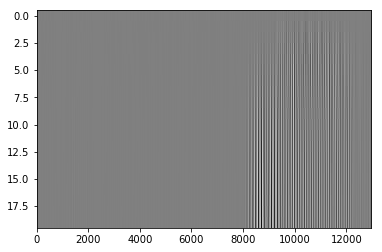

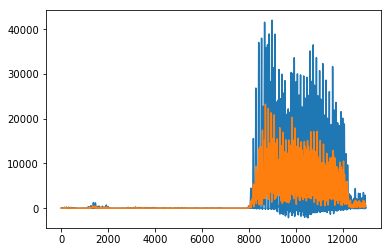


../input/train/audio/no/28e47b1a_nohash_1.wav


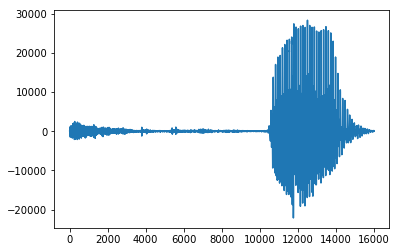

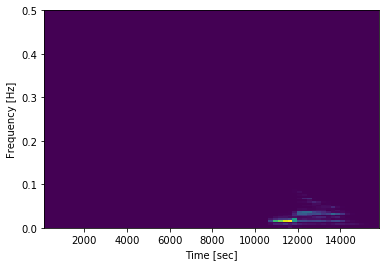

0.174514339681


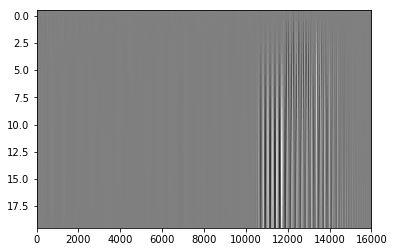

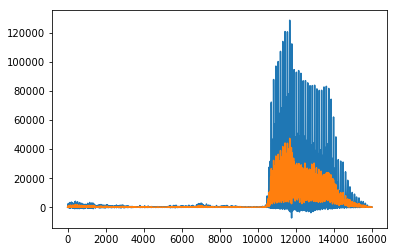


../input/train/audio/no/50b86bf8_nohash_0.wav


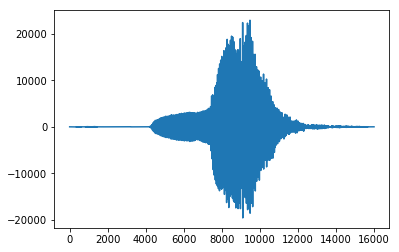

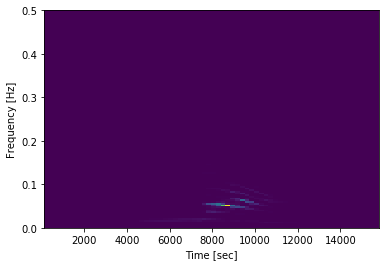

-0.00167385478729


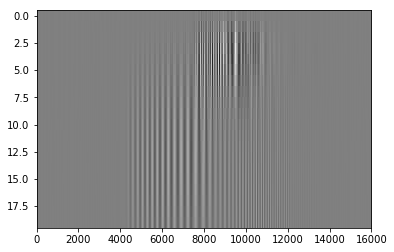

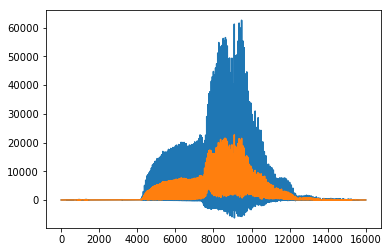


../input/train/audio/no/b7a0754f_nohash_4.wav


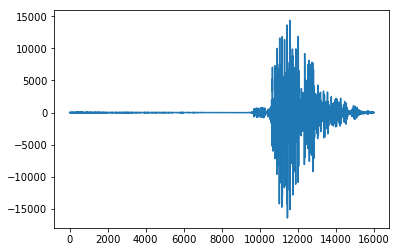

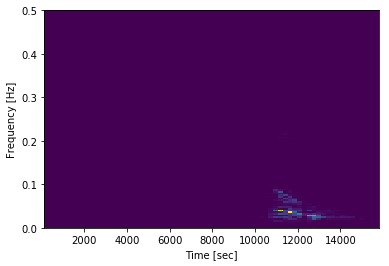

0.0064708018293


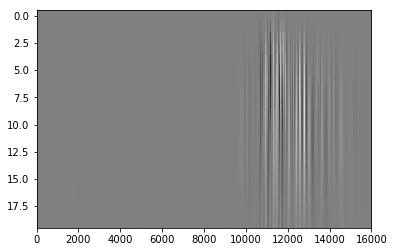

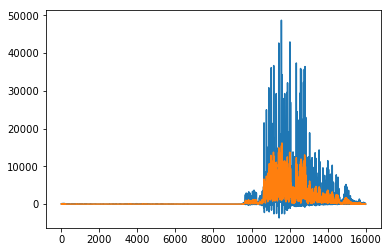


../input/train/audio/no/6982fc2a_nohash_0.wav


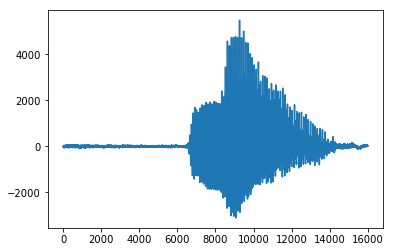

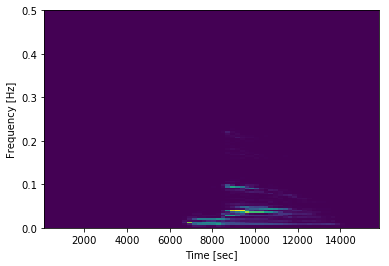

0.0472081784491


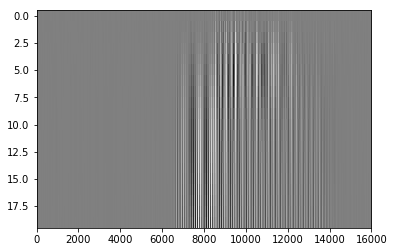

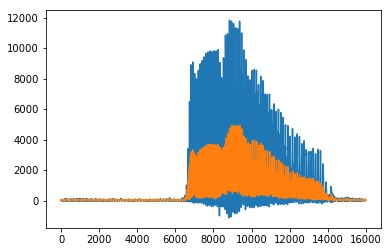


../input/train/audio/no/60472d26_nohash_1.wav


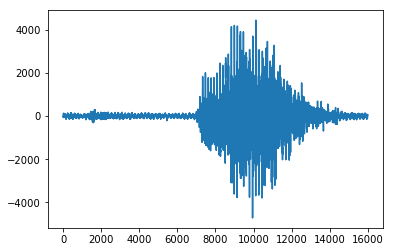

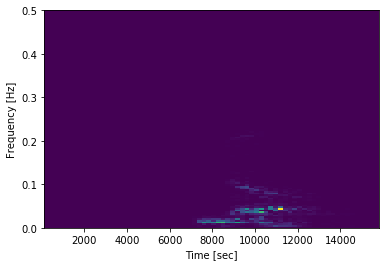

-0.0146833760019


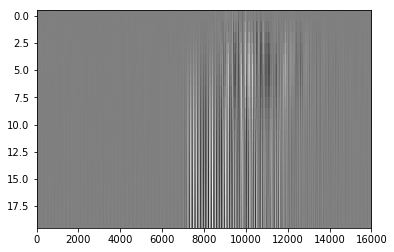

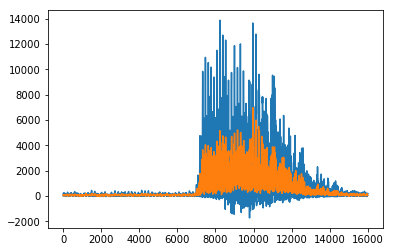


../input/train/audio/no/ffd2ba2f_nohash_3.wav


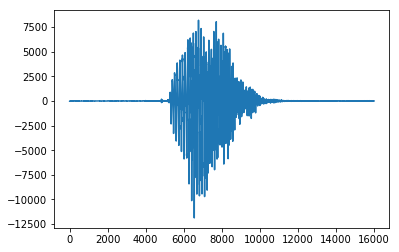

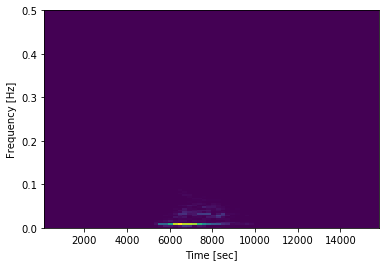

-0.00011699315883


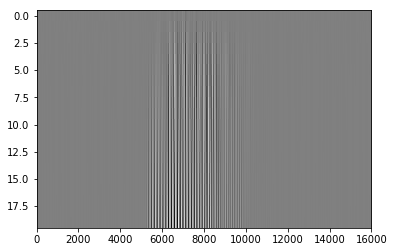

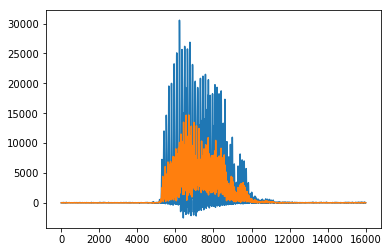


../input/train/audio/no/90b94017_nohash_1.wav


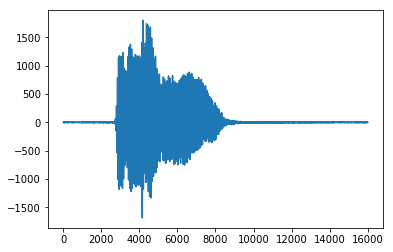

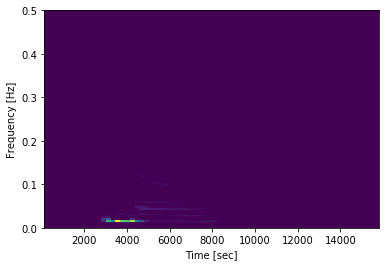

0.00195944147582


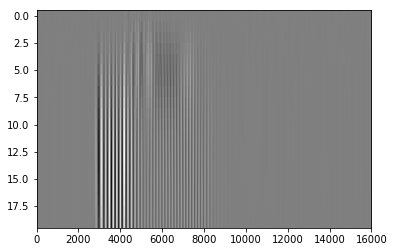

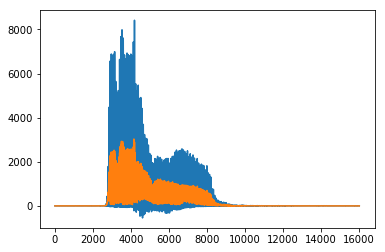


../input/train/audio/no/aba19127_nohash_2.wav


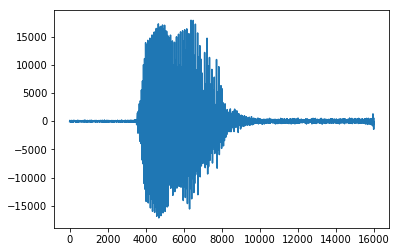

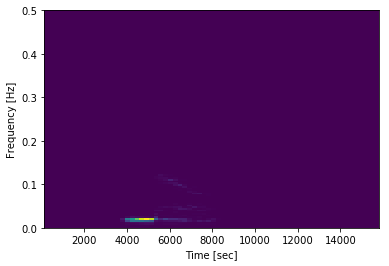

-1.5773819875


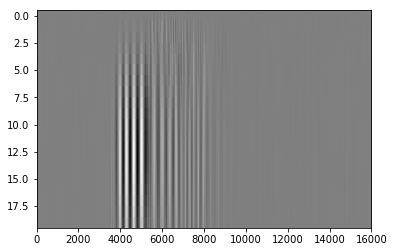

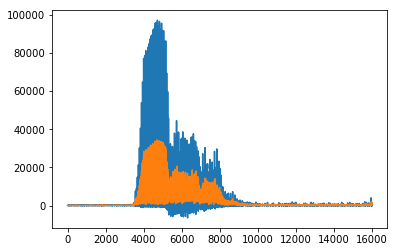

In [276]:
lst=!ls ../input/train/audio/no/*.wav
for fname in np.random.choice(lst,10,replace=False):
    print (fname)
    a,b=wavefile.read(fname)
    plt.plot(b);plt.show()
    f(b)
    ipd.Audio(b,rate=16000)
    print()

In [361]:
a,b=wavefile.read('../input/train/audio/no/012c8314_nohash_0.wav')
a

16000

In [377]:
a,b=wavefile.read('../input/train/audio/yes/00f0204f_nohash_2.wav')
a

16000

In [292]:
b=(b+c)/2

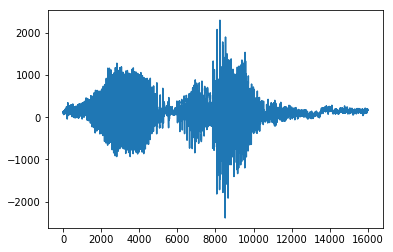

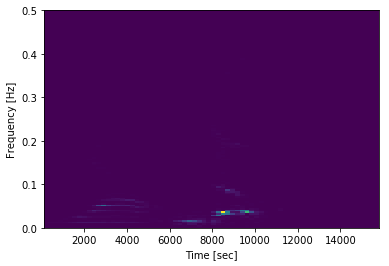

0.569980558609


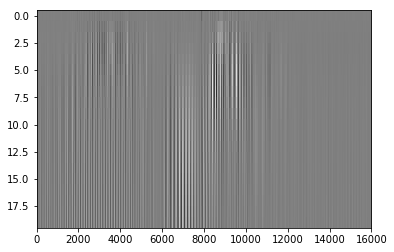

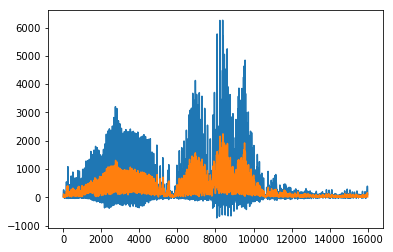

In [293]:
plt.plot(b);plt.show()
f(b)
ipd.Audio(b,rate=16000)
print()

In [294]:
ipd.Audio(b
          ,rate=16000)

In [378]:
widths = np.arange(1, 21)
cwtmatr = scipy.signal.cwt(b, scipy.signal.ricker, widths)

In [379]:
def g(x):
    a=[]
    b=[]
    c=[]
    d=[]
    i=0
    while i < x.shape[1]:
        xx= x[:,i:i+40]
        a.append(xx.mean())
        b.append(xx.std())
        xx=(xx-xx.mean())/(xx.std()+1e-8)
        #c.append(np.abs(xx).max(1))
        c.append((xx).max(1))

        d.append(xx.min(1))
        i+=40
    return np.array(a),np.array(b),np.array(c).T,np.array(d).T

In [380]:
16000/25

640.0

In [381]:
u,v,w,w2=g(cwtmatr)

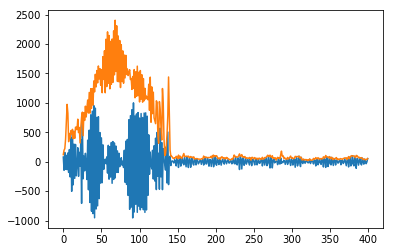

In [382]:
plt.plot(u);plt.plot(v);

In [383]:
w.shape

(20, 400)

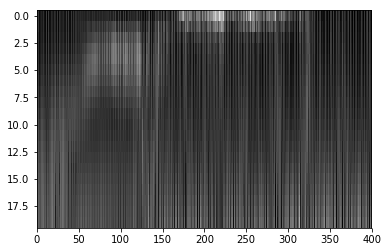

In [384]:
plt.imshow(w,cmap='gray',interpolation='nearest', aspect='auto')